# Transformada de Fourier

**Objetivos**
1. Implementar a *fast fourier transform*

**Resultado Esperado**
1. Entender qual é a matriz base do processamento musical

In [1]:
sh = """
LAB=lab04

echo "Baixando os arquivos do lab. Pode demorar um pouco."
if [ -f files.zip ]; then rm files.zip; fi
wget -q --no-check-certificate --show-progress \
        https://dcc.ufmg.br/~flaviovdf/mir/$LAB/files.zip
echo

if [ -f files.zip ]; then
    echo "Extraindo..."
    unzip -o files.zip
    if ! [ $? -eq 0 ]; then
        echo "Erro extraindo o arquivo!"
    fi
else
    echo "Arquivo não baixado!"
fi
"""
with open('script.sh', 'w') as file:
  file.write(sh)

! bash script.sh

Baixando os arquivos do lab. Pode demorar um pouco.
files.zip           100%[===================>]   1.39M   924KB/s    in 1.5s    

Extraindo...
Archive:  files.zip
  inflating: files/saida1.png        
  inflating: files/song.png          
  inflating: files/saida2.png        
  inflating: files/Scale_Chromatic_Piano.wav  


In [2]:
from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

plt.ion()

## Introdução

Como vimos em sala de aula, a Transformada de Fourier é o algoritmo base para realizar tarefas de Recuperação de Informação Musical. Durante as aulas, vimos três versões da transformada:

1. A transformada contínua
1. A transformada discreta
1. A transformada com janelas (ou *short time fourier transform (STFT)*)

Resumindo o assunto em texto, os sinais de áudio podem ser representados misturas complexas que consistem em uma infinidade de diferentes componentes de som. Tais componentes podem ser encontradas fazendo uso da transformada de Fourier. A mesma mapeia um sinal dependente do tempo para um espectro de frequências que revelam as frequências que das quais o áudio é composto.

Em termos simples, um sinal e sua Transformada de Fourier são dois lados da mesma moeda. Por um lado, o sinal exibe as informações de tempo e esconde o informações sobre frequências. Por outro lado, a transformação de Fourier revela informações sobre frequências e oculta as informações de tempo. Para obter de volta as informações de tempo ocultas, Dennis Gabor apresentou no ano de 1946, a transformada de Fourier STFT. 

## Transformada Discreta

A transformada de Fourier é definida como:

\begin{align}
X(k) = \sum_{n=0}^{N-1} e^{-2 \pi i n k / N} x(n) \\
x(n) = \frac{1}{N}\sum_{k=0}^{N-1} e^{2 \pi i n k / N} X(k)
\end{align}

$X(k)$ é a importância de uma frequência no índice $k$. $x(n)$ é o valor do sinal na posição $n$. Como vimos em sala de aula, a mesma pode ser escrita de forma matricial. Para tal, precisamos definir os vetores: $\mathbf{X}[k] = X(k)$ e $\mathbf{x}[n] = x(n)$. Após isto, podemos definir a matriz:

\begin{align}
{\displaystyle \text{DFT}_N ={\begin{pmatrix}1& 1&\cdots &1\\1&\omega^{11}&\cdots &\omega^{2(N-1)}\\\vdots &\vdots &\ddots &\vdots \\1&\omega^{(N-1)1}&\cdots &\omega^{(N-1)(N-1)}\end{pmatrix}}} 
\end{align}

Onde, 

\begin{align}
\omega^{kn} = (e^{-2 \pi i / N})^{kn} \\
\omega^{kn} = e^{-2 \pi kni / N}
\end{align}

Daqui, a transformada é simplesmente o produto: $\mathbf{X} = \text{DFT}_N \cdot \mathbf{x}$. Com, $\mathbf{X}[k] = X(k)$ e $\mathbf{x}[n] = x(n)$.

Sua primeira tarefa é implementar uma função Python que retorna a matriz $\text{DFT}_N$. Lembre-se que definimos $k \in [0, N)$ e $n \in [0, N)$. Tanto os coeficientes quanto o número de posições no sinal é o mesmo.

Observe como a função tem uma chamada `@jit` no começo. Tal chamada deixa o código mais rápido a ajuda os alunos que desejam gerar a matriz com laços. Dentro de funções dessa forma, a biblioteca *numba* compila o código para *C*. Então, você é limitado a usar comandos python, tipos simples como listas e vetores/matrizes numpy dentro da função.

In [3]:
@jit(nopython=True)
def generate_matrix_dft(N):
    M = np.zeros((N, N), dtype=np.complex128)    
    
    # Para k = 0 e n = 0 M[k, n] será 1 + 0i
    for k in range(N):
        for n in range(N):
            M[k, n] = np.exp((-2j * np.pi * k * n) / N)
    
    return M

O código abaixo vai plotar os coeficientes reais e imaginários da sua matriz. Observe como existe uma redundância. Aproximadamente uma metade de cada matriz (os blocos na digonais) são iguais. Isto vale tanto para a diagonal principal como a secundária. Tal matriz serve como evidência de que computamos mais coeficientes do que precisamos, algo que foi dito em sala de aula, na prática, apenas K/2 coeficientes seriam necessários. 

O código abaixo deve gerar uma saída como:

![](https://dcc.ufmg.br/~flaviovdf/mir/lab04/imgs/saida1.png)

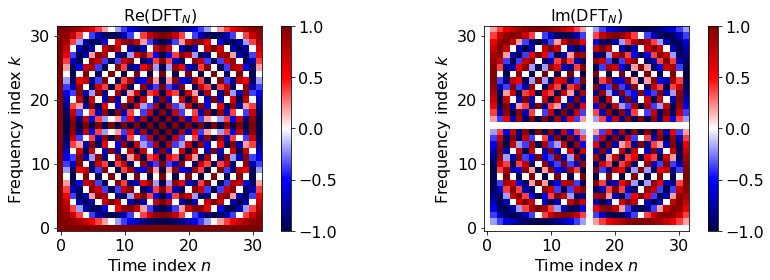

In [4]:
dft_mat = generate_matrix_dft(32)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('$\mathrm{Re}(\mathrm{DFT}_N)$')
plt.imshow(np.real(dft_mat), origin='lower', cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('$\mathrm{Im}(\mathrm{DFT}_N)$')
plt.imshow(np.imag(dft_mat), origin='lower', cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()
plt.tight_layout()

Agora escreva uma função para realizar a transformada:

In [5]:
@jit(nopython=True)
def dft(x):
    N = len(x)
    x_complex = x.astype(np.complex128)
    
    dft = generate_matrix_dft(N)
    X = np.dot(dft, x_complex)
    
    return X

Abaixo fazemos uso da sua função. O código abaixo deve gerar uma saída como:

![](https://dcc.ufmg.br/~flaviovdf/mir/lab04/imgs/saida2.png)

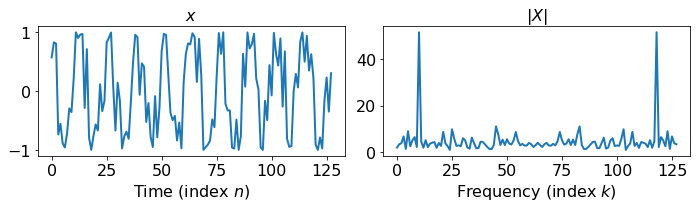

In [6]:
N = 128
n = np.arange(N)
k = 10
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 
X = dft(x)  # tive que adicionar isso pois estava no lugar errado

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('$x$')
plt.plot(x)
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(np.abs(X))
plt.xlabel('Frequency (index $k$)')
plt.tight_layout()

A seguir, discutimos a famosa transformada rápida de Fourier (Fast Fourier Transform - FFT). O algoritmo FFT foi originalmente descoberto por Gauss em volta de 1805. No ano de 1965, o mesmo foi então redescoberto por Cooley e Tukey em 1965. O algoritmo FFT é baseado na observação de que a aplicação de uma DFT de tamanho par $ N = 2M $ pode ser expressa em termos de aplicação de duas DFTs com metade do tamanho $ M $. O algoritmo explora o fato de que existem relações algébricas entre as entradas $\omega^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn}$ de matrizes DFT.

No algoritmo FFT, calcula-se o DFT dos elementos pares e ímpares de $x(n)$

\begin{align}
(A(0), \dots, A (N / 2-1)) & = \mathrm{DFT}_{N / 2} \cdot (x (0), x (2), x (4), \cdots, x (N-2)) \\
(B(0), \dots, B (N / 2-1)) & = \mathrm{DFT}_{N / 2} \cdot (x (1), x (3), x (5), \cdots, x (N-1))
\end{align}

Com esses dois DFTs de tamanho $N/2$, pode-se calcular o DFT completo de tamanho $N$ por meio de:

\begin{eqnarray}
C(k) & = & \sigma^k \cdot B(k) \\
X(k) & = & A(k) + C(k) \\
X(N / 2 + k) & = & A(k) - C(k) \\
\end{eqnarray}

para $ k \in [0: N / 2 - 1] $. Os números $\sigma^k$ também são chamados de *fatores de torção*. Se $N$ é uma potência de dois, esta ideia pode ser aplicada recusivamente até que se alcance o cálculo de $ \mathrm {DFT}_{1} $ (o caso $ N = 1 $), que é simplesmente multiplicação por um ( ou seja, apenas retornando o sinal de comprimento $ N = 1 $).


Por fim implemente o algoritmo FFT e plote o mesmo resultado do caso anterior. Os comandos python abaixo separam os pares dos ímpares!

```python
x = np.array([0, 1, 2, 3, 4, 5])
x_par = x[::2]
x_impar = x[1::2]
```

In [7]:
x = np.array([0, 1, 2, 3, 4, 5])
x_par = x[::2]
x_impar = x[1::2]

print(x_par)
print(x_impar)

[0 2 4]
[1 3 5]


In [8]:
@jit(nopython=True)
def fft(x):
    N = len(x)
    x_complex = x.astype(np.complex128)
    
    if N == 1:
        return x_complex
    
    A = fft(x_complex[::2])
    B = fft(x_complex[1::2])
    
    ks = np.arange(int(N/2))
    C = np.exp((-2j * np.pi * ks) / N) * B  # na fórmula é sigma^k, ou seja n = 1
    
    X = np.zeros(N, dtype=np.complex128)
    X[:int(N/2)] = A + C
    X[int(N/2):] = A - C
    
    return X

Compare o tempo de execução dos dois com a chamada abaixo:

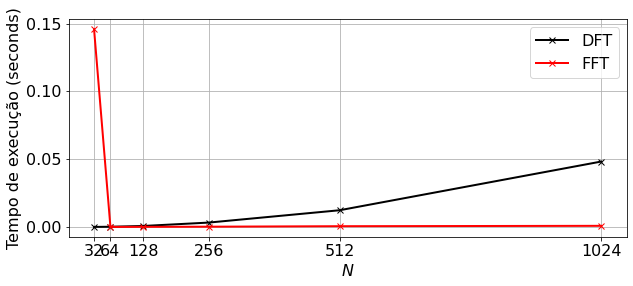

In [9]:
import timeit

Ns = [2 ** n for n in range(5, 11)]
times_dft = []
times_fft = []
execuctions = 10

for N in Ns:
    n = np.arange(N)
    x = np.sin(2 * np.pi * 5 * n / N )
    
    time_dft = timeit.timeit(lambda: dft(x), number=execuctions) / execuctions
    time_fft = timeit.timeit(lambda: fft(x), number=execuctions) / execuctions
    times_dft.append(time_dft)
    times_fft.append(time_fft)
    
plt.figure(figsize=(10, 4))
    
plt.plot(Ns, times_dft, '-xk', label='DFT')
plt.plot(Ns, times_fft, '-xr', label='FFT')
plt.xticks(Ns)
plt.legend()
plt.grid()
plt.xlabel('$N$')
plt.ylabel('Tempo de execução (seconds)');

In [10]:
# A primeira iteração acima está com um tempo de execução elevado já que o numba gasta tempo compilando o 
# código pela primeira vez.

In [11]:
# Apenas verificando se a função criada está correta
np.testing.assert_almost_equal(fft(x), dft(x))

## Sinal Real com FFT e STFT

Agora sua tarefa será aplicar a transformada em um sinal real.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab04/imgs/song.png)

O aúdio abaixo toca as notas do piano seguindo a escala cromática. A figura também mostra duas versões do espectograma. Sua resposta final deve parecer com a Fig (b).

In [12]:
ipd.Audio(filename='./files/Scale_Chromatic_Piano.wav')

Aplique a transformada de Fourier rápida no mesmo. Para tal, você pode fazer uso do pacote já pronto em python:

In [13]:
from scipy.fft import fft

In [14]:
song, F_s = librosa.load('./files/Scale_Chromatic_Piano.wav')
print(len(song))
print(F_s)

379776
22050


### FFT

O código abaixo carrega a música e indica sua taxa de frequência. Agora, sabendo dos dados abaixo, aplique a Transformada de Fourier usando seu código ou o scipy. Recomendo fazer uso do scipy por corretude! Após isto, responda.

**Questão**: Quais são as três frequência mais importante no sinal? Você deve converter entre índice e frequência aqui. Veja a equação nos slides. Além do mais, você deve descartar metade da saída do código do FFT, é redundante!

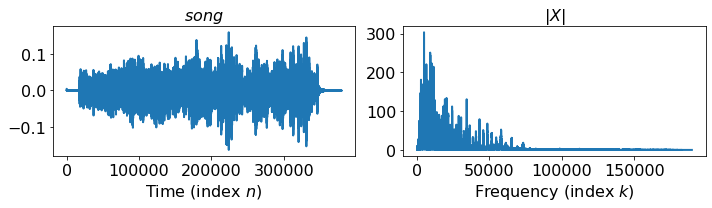

In [15]:
# Metade dos valores são simétricos (negativos)
X = np.abs(fft(song)[:len(song)//2])

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title('$song$')
plt.plot(song)
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(X)
plt.xlabel('Frequency (index $k$)')
plt.tight_layout()

In [16]:
sorted_indexes = np.argsort(X)[::-1]
top3_indexes = sorted_indexes[:3]

print('Frequências equivalentes aos índices')
for k in top3_indexes:
    freq = (k * F_s) / len(song)
    print('k={} -> {:.2f}Hz'.format(k, freq))

Frequências equivalentes aos índices
k=4792 -> 278.23Hz
k=4775 -> 277.24Hz
k=4791 -> 278.17Hz


- **Resposta:** A resposta foi dada através das células acima.

### STFT

Agora vamos fazer uso do código de STFT já pronto em Python. Leia a documentação do mesmo, observe como o mesmo recebe dois argumentos importantes (abaixo os nomes e valores padrão):

1. window='hann'
1. nperseg=256

O primeiro é o tipo de janela. O segundo é o número de elementos por janela.

In [17]:
from scipy.signal import stft

Observe como no plot eu coloquei o np.log para deixar as importâncias mais claras!

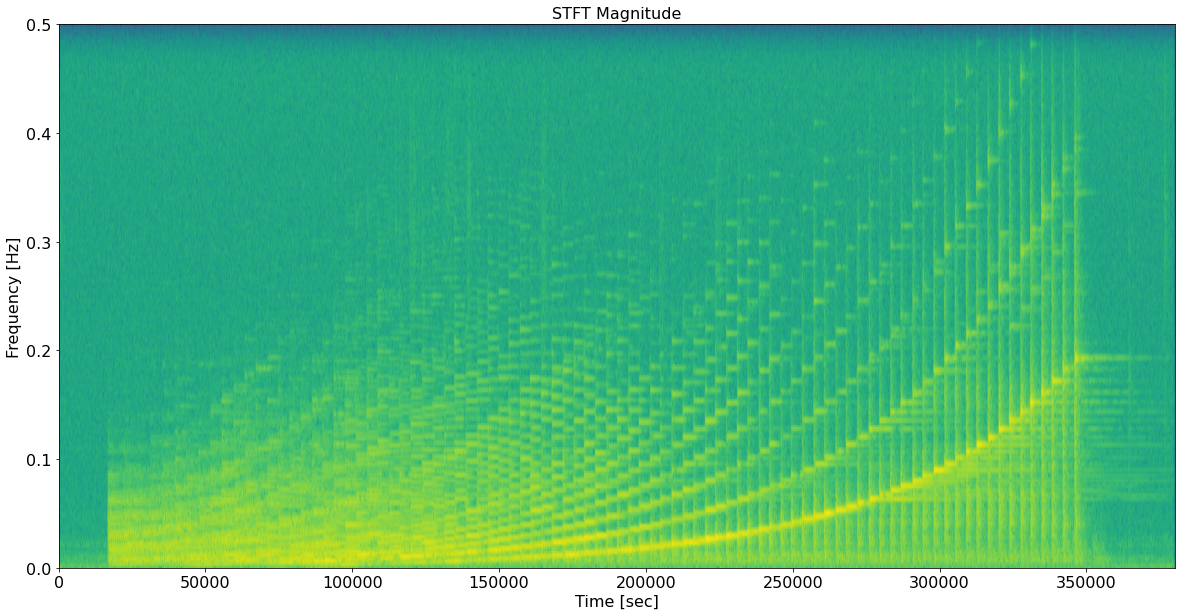

In [18]:
f, t, Zxx = stft(song, nperseg=500)

plt.figure(figsize=(20, 10))

plt.pcolormesh(t, f, np.log(np.abs(Zxx)), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

**Questão**: Para cada segundo da música, qual a frequência mais importante? Você pode fazer um código para responder esta questão.

In [19]:
# passando fs=F_s facilita a vida já que tanto o tempo como a frequência
# possuem os "valores reais" e não seus índices
f, t, Zxx = stft(song, fs=F_s, nperseg=500)

# Computando o tamanho de um segmento, ou seja,
# quantos segmentos equivalem à 1 segundo de música
seg_size = len(t[t <= 1])

seconds = len(song) // F_s
results = np.zeros(seconds)

# Percorrendo cada segundo e obtendo a frequência mais importante daquele segundo
for i in range(seconds):
    k = np.argmax(np.abs(Zxx[:, i*seg_size]))
    
    results[i] = f[k]
    print('Segundo {}: {:.2f}Hz'.format(i, f[k]))

Segundo 0: 88.20Hz
Segundo 1: 352.80Hz
Segundo 2: 264.60Hz
Segundo 3: 132.30Hz
Segundo 4: 132.30Hz
Segundo 5: 220.50Hz
Segundo 6: 441.00Hz
Segundo 7: 441.00Hz
Segundo 8: 573.30Hz
Segundo 9: 396.90Hz
Segundo 10: 573.30Hz
Segundo 11: 837.90Hz
Segundo 12: 1190.70Hz
Segundo 13: 1675.80Hz
Segundo 14: 2337.30Hz
Segundo 15: 3351.60Hz
Segundo 16: 176.40Hz


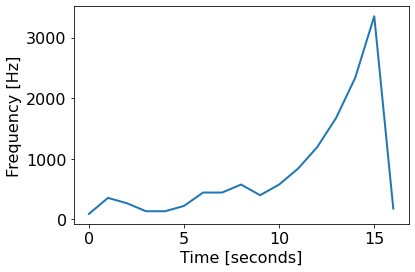

In [20]:
# Podemos perceber o mesmo comportamento exponencial do espectograma
plt.plot(results)
plt.xlabel('Time [seconds]')
plt.ylabel('Frequency [Hz]')
plt.show()

- Algo que eu não havia reparado é que a música não se inicia e para exatamente nos segundos 0 e 17, mas sim um pouco depois e um pouco antes, justificando as "pontas" da lista acima com uma frequência relativamente baixa.

- Abaixo fiz um outros 3 códigos (puramente experimentais) considerando agora o intervalo de 1 segundo como um todo e não apenas exatamente o segmento referente àquele segundo. Para isso, optei por analisar 3 estratégias:
    1. Olhar qual segmento possuia a maior importância, escolhendo ele como um "resumo" daquele intervalo;
    2. Escolher a frequência mais importante baseado na mediana das importâncias sobre aquele intervalo;
    3. Escolher a frequência mais importante baseado na média das importâncias sobre aquele intervalo;

In [21]:
# passando fs=F_s facilita a vida já que tanto o tempo como a frequência
# possuem os "valores reais" e não seus índices
f, t, Zxx = stft(song, fs=F_s, nperseg=500)

# Computando o tamanho de um segmento, ou seja,
# quantos segmentos equivalem à 1 segundo de música
seg_size = len(t[t <= 1])

seconds = len(song) // F_s
results = np.zeros(seconds)

# Percorrendo cada segundo e obtendo a frequência mais importante daquele segmento
for i in range(seconds):
    init, end = i*seg_size, (i+1)*seg_size
    values = np.abs(Zxx[:, init:end])
    
    seg_with_max = np.argmax(np.max(values, axis=0))
    k = np.argmax(values[:, seg_with_max])
    
    results[i] = f[k]
    print('Segundo {}: {:.2f}Hz'.format(i, f[k]))

Segundo 0: 396.90Hz
Segundo 1: 176.40Hz
Segundo 2: 176.40Hz
Segundo 3: 132.30Hz
Segundo 4: 264.60Hz
Segundo 5: 220.50Hz
Segundo 6: 396.90Hz
Segundo 7: 264.60Hz
Segundo 8: 396.90Hz
Segundo 9: 573.30Hz
Segundo 10: 617.40Hz
Segundo 11: 1102.50Hz
Segundo 12: 1411.20Hz
Segundo 13: 1984.50Hz
Segundo 14: 3351.60Hz
Segundo 15: 3792.60Hz
Segundo 16: 176.40Hz


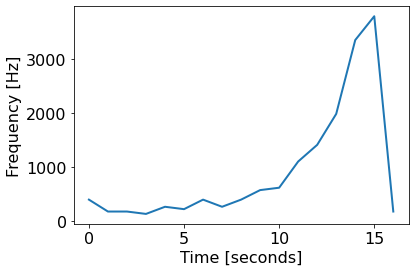

In [22]:
plt.plot(results)
plt.xlabel('Time [seconds]')
plt.ylabel('Frequency [Hz]')
plt.show()

In [23]:
# passando fs=F_s facilita a vida já que tanto o tempo como a frequência
# possuem os "valores reais" e não seus índices
f, t, Zxx = stft(song, fs=F_s, nperseg=500)

# Computando o tamanho de um segmento, ou seja,
# quantos segmentos equivalem à 1 segundo de música
seg_size = len(t[t <= 1])

seconds = len(song) // F_s
results = np.zeros(seconds)

# Percorrendo cada segundo e obtendo a mediana das importâncias daquele segmento
for i in range(seconds):
    init, end = i*seg_size, (i+1)*seg_size
    values = np.median(np.abs(Zxx[:, init:end]), axis=1)
    
    k = np.argmax(values)
    results[i] = f[k]
    print('Segundo {}: {:.2f}Hz'.format(i, f[k]))

Segundo 0: 44.10Hz
Segundo 1: 176.40Hz
Segundo 2: 176.40Hz
Segundo 3: 176.40Hz
Segundo 4: 176.40Hz
Segundo 5: 264.60Hz
Segundo 6: 352.80Hz
Segundo 7: 220.50Hz
Segundo 8: 352.80Hz
Segundo 9: 485.10Hz
Segundo 10: 661.50Hz
Segundo 11: 926.10Hz
Segundo 12: 1411.20Hz
Segundo 13: 1984.50Hz
Segundo 14: 2513.70Hz
Segundo 15: 132.30Hz
Segundo 16: 44.10Hz


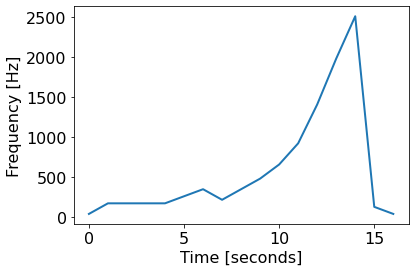

In [24]:
plt.plot(results)
plt.xlabel('Time [seconds]')
plt.ylabel('Frequency [Hz]')
plt.show()

In [25]:
# passando fs=F_s facilita a vida já que tanto o tempo como a frequência
# possuem os "valores reais" e não seus índices
f, t, Zxx = stft(song, fs=F_s, nperseg=500)

# Computando o tamanho de um segmento, ou seja,
# quantos segmentos equivalem à 1 segundo de música
seg_size = len(t[t <= 1])

seconds = len(song) // F_s
results = np.zeros(seconds)

# Percorrendo cada segundo e obtendo a média das importâncias daquele segmento
for i in range(len(song) // F_s):
    init, end = i*seg_size, (i+1)*seg_size
    values = np.mean(np.abs(Zxx[:, init:end]), axis=1)
    
    k = np.argmax(values)
    results[i] = f[k]
    print('Segundo {}: {:.2f}Hz'.format(i, f[k]))

Segundo 0: 352.80Hz
Segundo 1: 176.40Hz
Segundo 2: 176.40Hz
Segundo 3: 176.40Hz
Segundo 4: 264.60Hz
Segundo 5: 264.60Hz
Segundo 6: 352.80Hz
Segundo 7: 264.60Hz
Segundo 8: 352.80Hz
Segundo 9: 529.20Hz
Segundo 10: 661.50Hz
Segundo 11: 1102.50Hz
Segundo 12: 1411.20Hz
Segundo 13: 1984.50Hz
Segundo 14: 2513.70Hz
Segundo 15: 3792.60Hz
Segundo 16: 44.10Hz


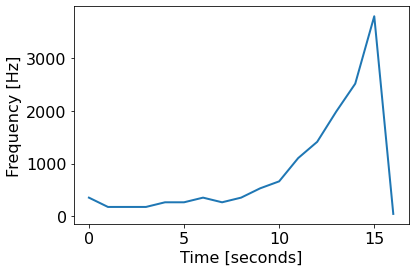

In [26]:
# Podemos perceber um comportamento exponencial parecido com o observado no espectrograma
plt.plot(results)
plt.xlabel('Time [seconds]')
plt.ylabel('Frequency [Hz]')
plt.show()